# Logistic Regression Predictive Model

We created a logistic regression model to predict whether a given pending water rights application would be approved or not permitted.

In [ ]:
# Run this cell to set up your notebook.  Make sure ds100_utils.py is in this assignment's folder
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import scipy
from scipy import stats


# Default plot configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, Latex, Markdown

### Data Preprocessing

In [ ]:
#Run this cell to see list of columns in the dataset
#Insp conatains number of violations
org = pd.read_csv('water-rights-status-history.csv')
insp = pd.read_csv('water-rights-inspections.csv')
insp.head(5)

,INSPECTION_ID,INSPECTION_DATE,INSPECTION_METHOD,INSPECTION_REPORT_DATE,INSPECTION_NOTES,NUM_INSPECTION,NUM_POI,POI_ID_1,POI_COUNTY_1,POI_SOURCE_1,...,NUM_OF_VIOLATIONS,ENF_CASE_NUMBER,ENFOCEMENT_ACTION_TYPE,ENF_CASE_CLOSURE_DATE,INVESTIGATION_LEAD_STAFF,INVEST_SECTION_OR_OFFICE,INVESTIGATION_SWEEP,RESOURCE_VALUE_PRIORITY,INVESTIGATION_SUMMARY,ASSOCIATED_WR_TO_INV
0,1,6/6/2008,NaN,6/6/2008,NaN,1,1.0,5576.0,Sonoma,Unnamed stream,...,0,NaN,NaN,NaN,Chuck Arnold,Water Rights - Enforcement,NaN,NaN,NaN,A031737
1,2,6/6/2012,Field,8/3/2012,NaN,1,1.0,1226.0,Napa,Tulucay Creek,...,2,ENF00518,Notification of Violations and Voluntary Compl...,NaN,Bill Rigby,Water Rights - Enforcement,NaN,NaN,Inspection found licensee out ot compliance wi...,A025455
2,3,10/15/2009,NaN,NaN,NaN,1,1.0,1359.0,San Joaquin,Unnamed stream,...,0,NaN,NaN,NaN,Matthew Quint,Water Rights - Enforcement,NaN,NaN,Request for Revocation by William Race. Unable...,A021472
3,4,10/17/2001,Field,5/23/2002,NaN,1,2.0,8162.0,Siskiyou,Stanshaw Creek,...,0,NaN,NaN,NaN,Michael Contreras,Water Rights - Enforcement,NaN,NaN,Likely lawful holder of a pre-1914 right for d...,"A029449,A029450,A029450,S015022,A029449,S015022"
4,5,11/17/2009,Field,3/29/2010,NaN,1,6.0,7681.0,Mendocino,Unnamed stream,...,1,ENF00945,Notification of Violations and Voluntary Compl...,4/22/2015,Laura Lavallee,Water Rights - Enforcement,NaN,NaN,Pursuant to Complaint 23-35-03 - Allegations f...,"A030966,A020971,A020971,A030966,S017021"


In [ ]:
df = pd.read_csv('water-rights-status-history.csv')


In [ ]:

df['water_ID'] = org['APPLICATION_NUMBER']

In [ ]:
#Use regex to match water ID from POI description and explode to get 1 row from each water right
pattern = '[A-Z]\d{6}'

insp['water_ID']= insp['POI_DESCRIPTION_1'].str.findall(pattern)
insp = insp.explode('water_ID')






ASSOCIATED_WR_TO_INV

In [ ]:
insp.head(2)

,INSPECTION_ID,INSPECTION_DATE,INSPECTION_METHOD,INSPECTION_REPORT_DATE,INSPECTION_NOTES,NUM_INSPECTION,NUM_POI,POI_ID_1,POI_COUNTY_1,POI_SOURCE_1,...,ENF_CASE_NUMBER,ENFOCEMENT_ACTION_TYPE,ENF_CASE_CLOSURE_DATE,INVESTIGATION_LEAD_STAFF,INVEST_SECTION_OR_OFFICE,INVESTIGATION_SWEEP,RESOURCE_VALUE_PRIORITY,INVESTIGATION_SUMMARY,ASSOCIATED_WR_TO_INV,water_ID
0,1,6/6/2008,NaN,6/6/2008,NaN,1,1.0,5576.0,Sonoma,Unnamed stream,...,NaN,NaN,NaN,Chuck Arnold,Water Rights - Enforcement,NaN,NaN,NaN,A031737,A031737
1,2,6/6/2012,Field,8/3/2012,NaN,1,1.0,1226.0,Napa,Tulucay Creek,...,ENF00518,Notification of Violations and Voluntary Compl...,NaN,Bill Rigby,Water Rights - Enforcement,NaN,NaN,Inspection found licensee out ot compliance wi...,A025455,A025455


In [ ]:
insp = pd.DataFrame(insp.groupby(by = 'water_ID').agg(lambda x: sum(x)))
type(insp)

pandas.core.frame.DataFrame

In [ ]:
insp = insp.reset_index()
insp.head(2)

,water_ID,INSPECTION_ID,NUM_INSPECTION,NUM_POI,POI_ID_1,POI_LATITUDE_1,POI_LONGITUDE_1,POI_ID_2,POI_LATITUDE_2,POI_LONGITUDE_2,POI_ID_3,POI_LATITUDE_3,POI_LONGITUDE_3,INVESTIGATION_ID,NUM_OF_VIOLATIONS
0,A000016,4275,1,4.0,8559.0,34.577972,-118.28921,8562.0,34.577972,-118.28921,8561.0,34.577972,-118.28921,10001,1
1,A000018,1534,1,5.0,7555.0,39.794500,-122.05450,7559.0,39.360000,-122.15300,7558.0,39.301000,-122.13500,7666,0


In [ ]:
#Merge original data with insp on water_ID
df = df.merge(insp, on = 'water_ID', how = 'left')
df.shape

(76504, 180)

Columns to fill in with mean: QUANTITY_OF_WATER_DIVERTED, USE_POPULATION

In [ ]:
#Manually check the quality of some columns by checking its sparsity. 
sum(pd.notnull(org['QUANTITY_OF_WATER_DIVERTED']) == True) #3581 not null / 76504 total
sum(pd.notnull(org['FACE_VALUE_AMOUNT']) == True) #72463 not null 
sum(pd.notnull(org['USE_COUNT']) == True) #76504 not null
sum(pd.notnull(org['USE_POPULATION']) == True) #47810 not null
sum(pd.notnull(org['NUMBER_OF_PROTESTS']) == True) #76463 not null
sum(pd.notnull(org['PRIMARY_OWNER_ENTITY_TYPE']) == True) #66494 not null
sum(pd.notnull(org['COUNT_NPO_OR_OTHER']) == True) #76504 not null
sum(pd.notnull(org['LATITUDE']) == True) #63161 not null

63161

This decides which water rights applications should be classified as "Approved" (A) or "Not Permitted" (NP). We classified approved water rights applications as the ones that were licensed, permitted, certified, registered, claimed, active, or completed. 

In [ ]:
df['A/NP'] = df['STATUS_AT_STATUS_EFFECTIVEDATE'].isin(['Licensed', 'Permitted', 'Certified', 'Registered', 'Claimed', 'Active', 'Completed'])


In [ ]:
#USE population has over one third as null and almost half as 0 so bad column
x = df[df['USE_POPULATION'].isnull()]
y = df[df['USE_POPULATION'] == 0]
x.shape, y.shape

((28694, 181), (39064, 181))

To deal with categorical data such as primary owner entity type and use code, we one-hot encoded the columns using pd.get_dummies, which turns the categorical data  into several quantitative data columns filled with 1's and 0's depending on the qualitative data value.


In [ ]:
df['FACE_VALUE_AMOUNT'] = df['FACE_VALUE_AMOUNT'].fillna(df['FACE_VALUE_AMOUNT'].mean())
df['NUMBER_OF_PROTESTS'] = df['NUMBER_OF_PROTESTS'].fillna(0)
df['LATITUDE'] = df['LATITUDE'].fillna(df['LATITUDE'].mean())
df['NUM_OF_VIOLATIONS'] = df['NUM_OF_VIOLATIONS'].fillna(0)


In [ ]:
#Split into train and val set
val = df[df['STATUS_AT_STATUS_EFFECTIVEDATE'] == 'Pending']
df = df[df['STATUS_AT_STATUS_EFFECTIVEDATE'] != 'Pending']

In [ ]:

#Only use the columns that are relevant and one hot encode the categorical columns 
df = df.loc[:, ['FACE_VALUE_AMOUNT', 'NUM_OF_VIOLATIONS', 'QUANTITY_OF_WATER_DIVERTED', 'USE_COUNT', 'USE_POPULATION', 'NUMBER_OF_PROTESTS', 'PRIMARY_OWNER_ENTITY_TYPE', 'COUNT_NPO_OR_OTHER', 'USE_CODE', 'LATITUDE', 'A/NP']]

df = pd.get_dummies(df, columns = ['PRIMARY_OWNER_ENTITY_TYPE', 'USE_CODE'] , drop_first = True)

df.insert(len(df.columns) - 1, 'A/NP', df.pop('A/NP'))
#len(df.columns)

In [ ]:
val = val.loc[:, ['FACE_VALUE_AMOUNT', 'NUM_OF_VIOLATIONS', 'QUANTITY_OF_WATER_DIVERTED', 'USE_COUNT', 'USE_POPULATION', 'NUMBER_OF_PROTESTS', 'PRIMARY_OWNER_ENTITY_TYPE', 'COUNT_NPO_OR_OTHER', 'USE_CODE', 'LATITUDE', 'A/NP']]

val = pd.get_dummies(val, columns = ['PRIMARY_OWNER_ENTITY_TYPE', 'USE_CODE'], drop_first = True )

val.insert(len(val.columns) - 1, 'A/NP', val.pop('A/NP'))

In [ ]:
 
df, val = df.align(val, join='inner', axis=1)  # inner join

In [ ]:
df['USE_COUNT'] = stats.zscore(df['USE_COUNT'])
df['NUMBER_OF_PROTESTS'] = stats.zscore(df['NUMBER_OF_PROTESTS'])
df['FACE_VALUE_AMOUNT'] = stats.zscore(df['FACE_VALUE_AMOUNT'])
df['NUM_OF_VIOLATIONS'] = stats.zscore(df['NUM_OF_VIOLATIONS'])
df['COUNT_NPO_OR_OTHER'] = stats.zscore(df['COUNT_NPO_OR_OTHER'])
df['LATITUDE'] = stats.zscore(df['LATITUDE'])


In [ ]:
val['USE_COUNT'] = stats.zscore(val['USE_COUNT'])
val['NUMBER_OF_PROTESTS'] = stats.zscore(val['NUMBER_OF_PROTESTS'])
val['FACE_VALUE_AMOUNT'] = stats.zscore(val['FACE_VALUE_AMOUNT'])
val['NUM_OF_VIOLATIONS'] = stats.zscore(val['NUM_OF_VIOLATIONS'])
val['COUNT_NPO_OR_OTHER'] = stats.zscore(val['COUNT_NPO_OR_OTHER'])
val['LATITUDE'] = stats.zscore(val['LATITUDE'])

In [ ]:
#Create new columns indicating if we have data on specific feature
df['QUANT_INCLUDED'] = pd.isnull(df['QUANTITY_OF_WATER_DIVERTED'])
df['USE_POP_INC'] = pd.isnull(df['USE_POPULATION'])

df.insert(len(df.columns) - 1, 'A/NP', df.pop('A/NP'))
df.head(5)


,FACE_VALUE_AMOUNT,NUM_OF_VIOLATIONS,QUANTITY_OF_WATER_DIVERTED,USE_COUNT,USE_POPULATION,NUMBER_OF_PROTESTS,COUNT_NPO_OR_OTHER,LATITUDE,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,...,USE_CODE_Mining,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering,QUANT_INCLUDED,USE_POP_INC,A/NP
1,-0.040209,-0.134215,NaN,-0.266105,0.0,-0.063596,-0.541558,-2.808115,0,0,...,0,0,0,0,0,0,0,True,False,False
2,-0.040418,3.326370,NaN,0.659908,0.0,-0.063596,0.634210,-1.821476,0,0,...,0,0,0,0,0,0,0,True,False,True
3,0.334877,-0.134215,NaN,0.659908,NaN,-0.063596,1.222094,0.799689,0,0,...,0,0,0,0,0,0,0,True,True,True
4,0.269597,3.326370,NaN,1.585921,0.0,-0.063596,-0.541558,-0.603169,0,1,...,0,0,0,0,0,0,0,True,False,True
5,-0.040491,-0.134215,NaN,-0.266105,0.0,-0.063596,1.809978,0.310917,0,0,...,0,0,0,0,0,0,0,True,False,True


In [ ]:
val['QUANT_INCLUDED'] = pd.isnull(val['QUANTITY_OF_WATER_DIVERTED'])
val['USE_POP_INC'] = pd.isnull(val['USE_POPULATION'])

val.insert(len(val.columns) - 1, 'A/NP', val.pop('A/NP'))
val.head(5)

,FACE_VALUE_AMOUNT,NUM_OF_VIOLATIONS,QUANTITY_OF_WATER_DIVERTED,USE_COUNT,USE_POPULATION,NUMBER_OF_PROTESTS,COUNT_NPO_OR_OTHER,LATITUDE,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,...,USE_CODE_Mining,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering,QUANT_INCLUDED,USE_POP_INC,A/NP
0,-0.115126,-0.152405,NaN,-0.553867,0.0,-0.311804,-0.580368,-4.036778,0,0,...,0,0,0,0,0,0,0,True,False,False
13,-0.112183,-0.152405,NaN,0.107382,0.0,0.446375,0.771205,-3.135666,0,0,...,0,0,0,0,0,0,0,True,False,False
34,3.433175,-0.152405,NaN,0.107382,0.0,-0.311804,-0.580368,-1.144123,0,1,...,0,0,0,0,0,0,0,True,False,False
44,-0.070110,3.709988,NaN,-0.553867,0.0,-0.311804,-0.580368,-0.624722,0,0,...,0,0,0,0,0,0,0,True,False,False
48,-0.115205,-0.152405,NaN,0.107382,0.0,-0.311804,-0.310053,1.049860,0,0,...,0,0,0,0,0,0,0,True,False,False


In [ ]:
df = df.drop(columns = ['QUANTITY_OF_WATER_DIVERTED', 'USE_POPULATION'])
val = val.drop(columns = ['QUANTITY_OF_WATER_DIVERTED', 'USE_POPULATION'])


In [ ]:
list(df.columns)

['FACE_VALUE_AMOUNT',
 'NUM_OF_VIOLATIONS',
 'USE_COUNT',
 'NUMBER_OF_PROTESTS',
 'COUNT_NPO_OR_OTHER',
 'LATITUDE',
 'PRIMARY_OWNER_ENTITY_TYPE_Estate',
 'PRIMARY_OWNER_ENTITY_TYPE_Federal Government',
 'PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)',
 'PRIMARY_OWNER_ENTITY_TYPE_Individual',
 'PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company',
 'PRIMARY_OWNER_ENTITY_TYPE_Limited Partner',
 'PRIMARY_OWNER_ENTITY_TYPE_Organization/Association',
 'PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners',
 'PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary',
 'PRIMARY_OWNER_ENTITY_TYPE_Trust',
 'USE_CODE_Aquaculture',
 'USE_CODE_Domestic',
 'USE_CODE_Dust Control',
 'USE_CODE_Fire Protection',
 'USE_CODE_Fish and Wildlife Preservation and Enhancement',
 'USE_CODE_Frost Protection',
 'USE_CODE_Heat Control',
 'USE_CODE_Incidental Power',
 'USE_CODE_Industrial',
 'USE_CODE_Irrigation',
 'USE_CODE_Mining',
 'USE_CODE_Municipal',
 'USE_CODE_Other',
 'USE_CODE_Power',
 'USE_CODE_Recreati

Feature: 0, Score: 0.23183
Feature: 1, Score: 0.13091
Feature: 2, Score: -0.15158
Feature: 3, Score: -0.13387
Feature: 4, Score: 0.22740
Feature: 5, Score: 0.19830
Feature: 6, Score: 0.72498
Feature: 7, Score: 1.30125
Feature: 8, Score: 0.96022
Feature: 9, Score: -0.10743
Feature: 10, Score: 0.72734
Feature: 11, Score: 0.88241
Feature: 12, Score: 0.70256
Feature: 13, Score: -0.01617
Feature: 14, Score: 0.25300
Feature: 15, Score: 0.39741
Feature: 16, Score: 0.76723
Feature: 17, Score: 0.49217
Feature: 18, Score: 1.42972
Feature: 19, Score: 0.98996
Feature: 20, Score: 1.37520
Feature: 21, Score: 0.72742
Feature: 22, Score: 0.79643
Feature: 23, Score: 0.37793
Feature: 24, Score: 0.05015
Feature: 25, Score: 0.38743
Feature: 26, Score: -0.34900
Feature: 27, Score: 0.01231
Feature: 28, Score: -0.64386
Feature: 29, Score: 0.49097
Feature: 30, Score: 1.31222
Feature: 31, Score: -0.05731
Feature: 32, Score: 1.39523
Feature: 33, Score: -0.58019
Feature: 34, Score: -0.31661


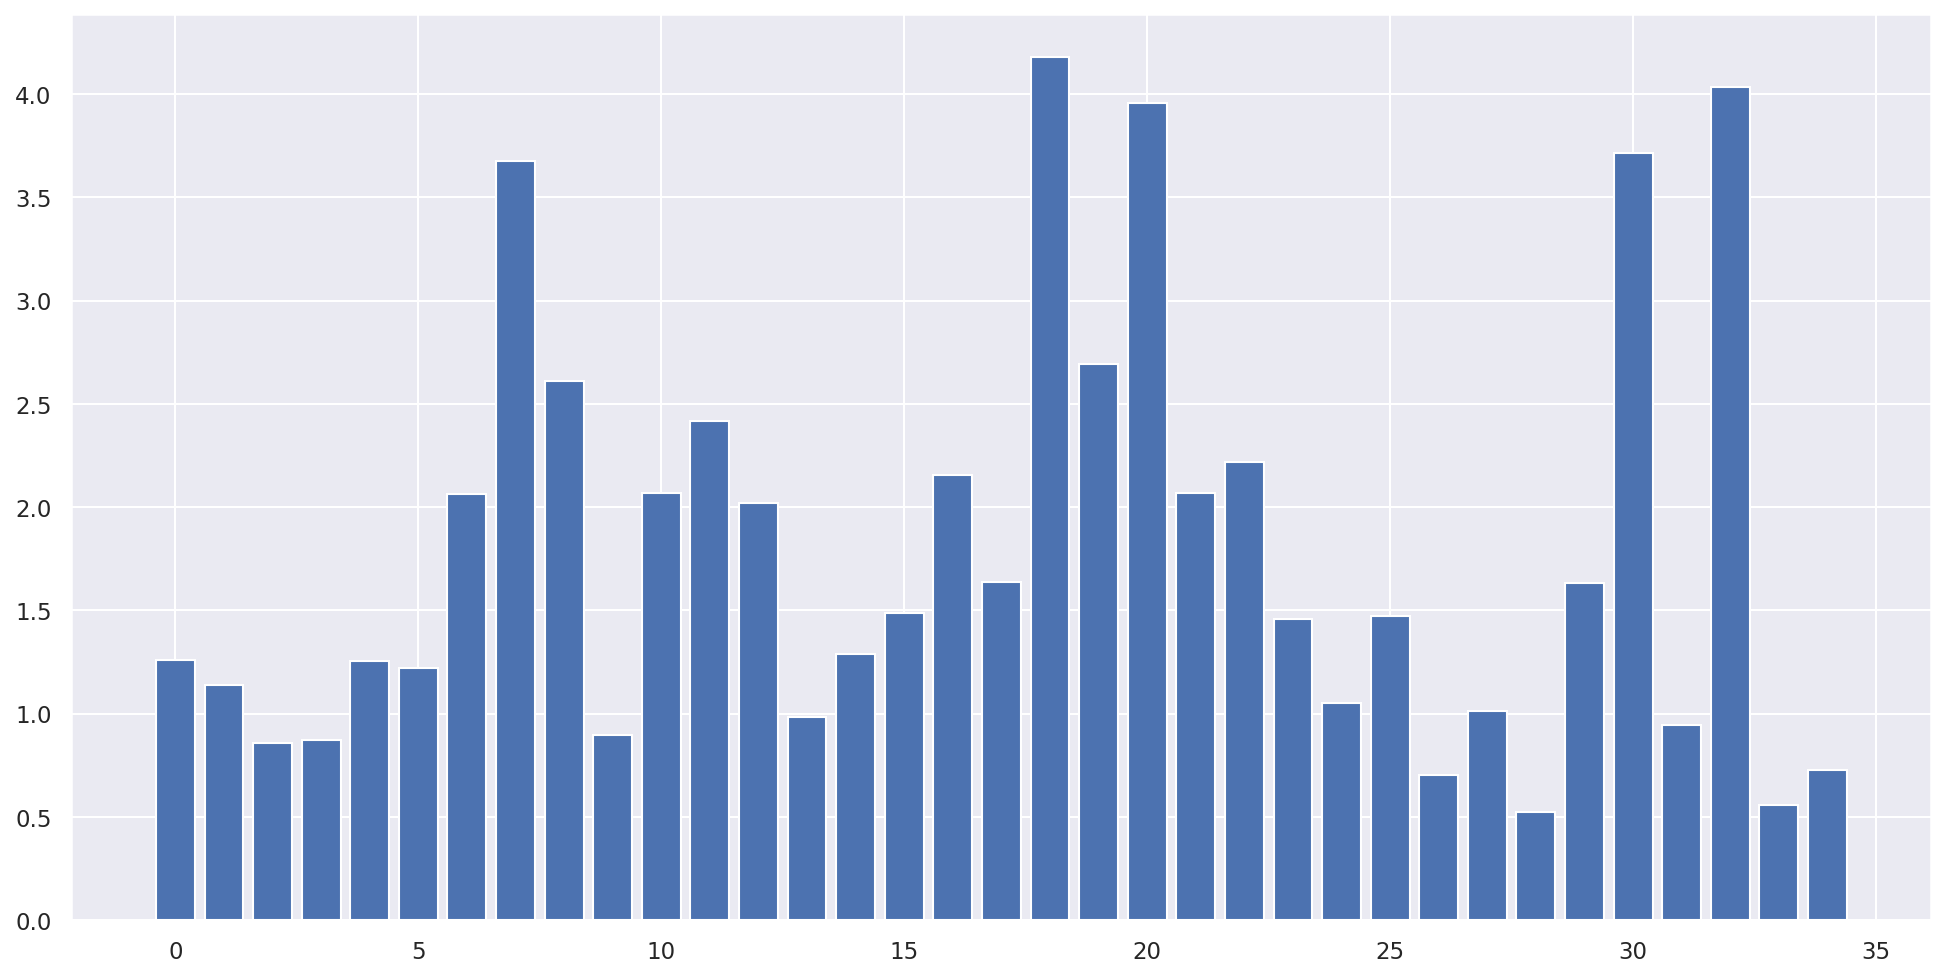

In [ ]:
# logistic regression for feature importance
import math
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X, y = df.iloc[:, : -1], df.iloc[:, -1]

# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], np.power(math.e, importance))
pyplot.show()

We've used regex to group our one-hot-encoded data columns to ensure that we add all the encoded columns at once. 

In [ ]:
#Use regex to find all the Primary columns after one hot econoding
import re

r = re.compile('PRIMARY')
vmatch = np.vectorize(lambda x:bool(r.match(x)))

A = df.columns
sel = vmatch(A)
sel

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [ ]:
r = re.compile('USE_CODE')
vmatch = np.vectorize(lambda x:bool(r.match(x)))
A = df.columns
ye = vmatch(A)
ye 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False])

In [ ]:

#set prim_owner to list of all column names cotaining primary_owne
prim_owner = df.columns[sel]
type(prim_owner)
use_code = df.columns[ye]

This iterates through our master list of all features that might affect the approval of a water right application and creates a list that contains various combinations of each feature.

In [ ]:
import itertools

stuff = ['USE_COUNT',  'NUMBER_OF_PROTESTS', 'QUANT_INCLUDED', 'USE_POP_INC', 'LATITUDE', 'NUM_OF_VIOLATIONS']
combos = []
for L in range(0, len(stuff)+1):
    for subset in itertools.combinations(stuff, L):
        combos.append(subset)
        
combos = combos[1: ]
combos





[('USE_COUNT',),
 ('NUMBER_OF_PROTESTS',),
 ('QUANT_INCLUDED',),
 ('USE_POP_INC',),
 ('LATITUDE',),
 ('NUM_OF_VIOLATIONS',),
 ('USE_COUNT', 'NUMBER_OF_PROTESTS'),
 ('USE_COUNT', 'QUANT_INCLUDED'),
 ('USE_COUNT', 'USE_POP_INC'),
 ('USE_COUNT', 'LATITUDE'),
 ('USE_COUNT', 'NUM_OF_VIOLATIONS'),
 ('NUMBER_OF_PROTESTS', 'QUANT_INCLUDED'),
 ('NUMBER_OF_PROTESTS', 'USE_POP_INC'),
 ('NUMBER_OF_PROTESTS', 'LATITUDE'),
 ('NUMBER_OF_PROTESTS', 'NUM_OF_VIOLATIONS'),
 ('QUANT_INCLUDED', 'USE_POP_INC'),
 ('QUANT_INCLUDED', 'LATITUDE'),
 ('QUANT_INCLUDED', 'NUM_OF_VIOLATIONS'),
 ('USE_POP_INC', 'LATITUDE'),
 ('USE_POP_INC', 'NUM_OF_VIOLATIONS'),
 ('LATITUDE', 'NUM_OF_VIOLATIONS'),
 ('USE_COUNT', 'NUMBER_OF_PROTESTS', 'QUANT_INCLUDED'),
 ('USE_COUNT', 'NUMBER_OF_PROTESTS', 'USE_POP_INC'),
 ('USE_COUNT', 'NUMBER_OF_PROTESTS', 'LATITUDE'),
 ('USE_COUNT', 'NUMBER_OF_PROTESTS', 'NUM_OF_VIOLATIONS'),
 ('USE_COUNT', 'QUANT_INCLUDED', 'USE_POP_INC'),
 ('USE_COUNT', 'QUANT_INCLUDED', 'LATITUDE'),
 ('USE_COUNT

The next two cell blocks add the grouped categorical variables to the list of combinations of features so that all columns containing information about the variables are added at once. 

In [ ]:
final_1 = [prim_owner]
for a in combos:
    b = list(a)
    c = np.concatenate((b, prim_owner))
    final_1.append(c)
    


In [ ]:
final_2 = [use_code]
for a in final_1:
    b = list(a)
    c = np.concatenate((b, use_code))
    final_2.append(c)



Next, we standardized our data using the z-score. We did this to ensure that there will be less noise in our data that has the risk of skewing our model.

Below we checked the number of water rights declared approved vs those not approved to validate our model's accuracy. 

In [ ]:
df["A/NP"] = df["A/NP"].astype(int)
df[df['A/NP'] == 1].shape, df.shape

((57081, 36), (72994, 36))

In [ ]:
val["A/NP"] = val["A/NP"].astype(int)
val.shape

(3510, 36)

ACTION ITEMS:

California Water right Inspection Dataset, use POI_DESCRIPTION_1 and regex to get Application ID, join table and use number of violations as feature, Standardize the features: https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f
https://towardsdatascience.com/logistic-regression-explained-593e9ddb7c6c

### Logistic Regression Model

We implemented a logistic regression model with our preprocessed data to predict whether a given water right application will be approved or not. We used feature selection to determine the best combination of independent variables that would help in predicting likelihood of approval.

'QUANTITY_OF_WATER_DIVERTED', 'USE_COUNT', 'NUMBER_OF_PROTESTS': 0.7495147938368915
'USE_POPULATION', 'NUMBER_OF_PROTESTS', prim_owner: 0.7499108805006536, 'USE_COUNT', 'NUM_OF_PROTESTS, prim_own,use_code: 0.7519309224858399, 'USE_COUNT', 'NUMBER_OF_PROTESTS', 'QUANT_INCLUDED', 'USE_POP_INC', PRIMARY_ENTITY, USE_CODE : 0.7533568344753833

In [ ]:

df.isnull().any()

FACE_VALUE_AMOUNT                                          False
NUM_OF_VIOLATIONS                                          False
USE_COUNT                                                  False
NUMBER_OF_PROTESTS                                         False
COUNT_NPO_OR_OTHER                                         False
LATITUDE                                                   False
PRIMARY_OWNER_ENTITY_TYPE_Estate                           False
PRIMARY_OWNER_ENTITY_TYPE_Federal Government               False
PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)     False
PRIMARY_OWNER_ENTITY_TYPE_Individual                       False
PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company        False
PRIMARY_OWNER_ENTITY_TYPE_Limited Partner                  False
PRIMARY_OWNER_ENTITY_TYPE_Organization/Association         False
PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners         False
PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary           False
PRIMARY_OWNER_ENTITY_TYPE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
models = []
highest_so_far = 0
best_feats = []
eval_nums = []
the_tp = 0
the_p = 0
the_fp = 0
the_fn = 0 
the_tn = 0 
predictions = None

for features in final_2: 
    X = df.loc[:, features]
    
    y = df.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
    
    
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
        
    y_test = y_test.to_numpy()
    
    predicts = model.predict(X_test)
    tp = np.sum((predicts == 1) & (y_test == 1))
    tn = np.sum((predicts == 0) & (y_test == 0))

    fp = np.sum((predicts == 1) & (y_test == 0))
    fn = np.sum((predicts == 0) & (y_test == 1))
    Precision = tp / (tp + fp)
    Recall = tp/ (tp + fn)
    f_1_score = 2 * (Precision * Recall) / (Precision + Recall)

    
    eval_nums.append(f_1_score)
        



    if f_1_score > highest_so_far: 
        the_tp = tp
        the_fp = fp
        the_tn = tn
        the_fn = fn
        highest_so_far = f_1_score      
        models.append(model)
        best_feats.append(features)
        predictions = model.predict(X_test)
        

           
best = best_feats[-1]
highest_so_far, best, 


    



(0.8784464381925086,
 array(['USE_COUNT', 'QUANT_INCLUDED', 'LATITUDE',
        'PRIMARY_OWNER_ENTITY_TYPE_Estate',
        'PRIMARY_OWNER_ENTITY_TYPE_Federal Government',
        'PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)',
        'PRIMARY_OWNER_ENTITY_TYPE_Individual',
        'PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company',
        'PRIMARY_OWNER_ENTITY_TYPE_Limited Partner',
        'PRIMARY_OWNER_ENTITY_TYPE_Organization/Association',
        'PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners',
        'PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary',
        'PRIMARY_OWNER_ENTITY_TYPE_Trust', 'USE_CODE_Aquaculture',
        'USE_CODE_Domestic', 'USE_CODE_Dust Control',
        'USE_CODE_Fire Protection',
        'USE_CODE_Fish and Wildlife Preservation and Enhancement',
        'USE_CODE_Frost Protection', 'USE_CODE_Heat Control',
        'USE_CODE_Incidental Power', 'USE_CODE_Industrial',
        'USE_CODE_Irrigation', 'USE_CODE_Mining', 'USE_CODE_Municipa

In [ ]:
models[-1].coef_

array([[-0.12680069, -0.49684055,  0.20560288,  0.90037494,  1.20516334,
         0.99082541, -0.04592837,  0.81808715,  1.01320687,  0.78381997,
         0.20753377,  0.18981932,  0.47315484,  1.0964044 ,  0.80967679,
         1.57134417,  1.30924595,  1.57541951,  0.98981758,  0.76535502,
         0.54527413,  0.47193259,  0.68874061, -0.17833455,  0.19784244,
        -0.53283182,  0.94956777,  1.64510505, -0.03707982,  1.66662679]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.03      0.05      5294
           1       0.78      1.00      0.88     18795

    accuracy                           0.78     24089
   macro avg       0.78      0.51      0.47     24089
weighted avg       0.78      0.78      0.70     24089



Best F1 score: 0.8784350474405528

Best features: ['USE_COUNT', 'NUMBER_OF_PROTESTS', 'QUANT_INCLUDED', 'LATITUDE',
        'PRIMARY_OWNER_ENTITY_TYPE_Estate',
        'PRIMARY_OWNER_ENTITY_TYPE_Federal Government',
        'PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)',
        'PRIMARY_OWNER_ENTITY_TYPE_Individual',
        'PRIMARY_OWNER_ENTITY_TYPE_Joint Venture',
        'PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company',
        'PRIMARY_OWNER_ENTITY_TYPE_Limited Partner',
        'PRIMARY_OWNER_ENTITY_TYPE_Organization/Association',
        'PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners',
        'PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary',
        'PRIMARY_OWNER_ENTITY_TYPE_Trust', 'USE_CODE_Aquaculture',
        'USE_CODE_Domestic', 'USE_CODE_Dust Control',
        'USE_CODE_Fire Protection',
        'USE_CODE_Fish and Wildlife Preservation and Enhancement',
        'USE_CODE_Frost Protection', 'USE_CODE_Heat Control',
        'USE_CODE_Incidental Power', 'USE_CODE_Industrial',
        'USE_CODE_Irrigation', 'USE_CODE_Milling', 'USE_CODE_Mining',
        'USE_CODE_Municipal', 'USE_CODE_Other', 'USE_CODE_Power',
        'USE_CODE_Recreational', 'USE_CODE_Snow Making',
        'USE_CODE_Stockwatering', 'USE_CODE_Water Quality']

In [ ]:
np.mean([1.09640021,  0.80970263,
         1.57133303,  1.30924651,  1.57535537,  0.98984211,  0.76541329,
         0.54546276,  0.47185806,  0.68877228, -0.17845401,  0.19787049,
        -0.53284911,  0.94960489,  1.645136  , -0.03709372,  1.66666025 ])

0.7961330023529412

In [ ]:
X_train.head(2)

,USE_COUNT,NUMBER_OF_PROTESTS,QUANT_INCLUDED,USE_POP_INC,LATITUDE,NUM_OF_VIOLATIONS,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal),PRIMARY_OWNER_ENTITY_TYPE_Individual,...,USE_CODE_Incidental Power,USE_CODE_Industrial,USE_CODE_Irrigation,USE_CODE_Mining,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering
43154,1.585921,-0.063596,True,False,-0.576724,-0.134215,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36213,0.659908,-0.063596,True,False,-0.603162,-0.134215,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
val.head(2)

,FACE_VALUE_AMOUNT,NUM_OF_VIOLATIONS,USE_COUNT,NUMBER_OF_PROTESTS,COUNT_NPO_OR_OTHER,LATITUDE,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal),PRIMARY_OWNER_ENTITY_TYPE_Individual,...,USE_CODE_Mining,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering,QUANT_INCLUDED,USE_POP_INC,A/NP
0,-0.115126,-0.152405,-0.553867,-0.311804,-0.580368,-4.036778,0,0,0,0,...,0,0,0,0,0,0,0,True,False,0
13,-0.112183,-0.152405,0.107382,0.446375,0.771205,-3.135666,0,0,0,0,...,0,0,0,0,0,0,0,True,False,0


In [ ]:
r = re.compile('USE_CODE')
vmatch = np.vectorize(lambda x:bool(r.match(x)))
A = val.columns
use_1 = vmatch(A)
r = re.compile('PRIMARY_OWNER_ENTITY_TYPE')
vmatch = np.vectorize(lambda x:bool(r.match(x)))
A = val.columns
prim_1 = vmatch(A)


In [ ]:
prim_owner_val = val.columns[prim_1]

use_code_val = val.columns[use_1]
prim_owner_val

Index(['PRIMARY_OWNER_ENTITY_TYPE_Estate',
       'PRIMARY_OWNER_ENTITY_TYPE_Federal Government',
       'PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)',
       'PRIMARY_OWNER_ENTITY_TYPE_Individual',
       'PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company',
       'PRIMARY_OWNER_ENTITY_TYPE_Limited Partner',
       'PRIMARY_OWNER_ENTITY_TYPE_Organization/Association',
       'PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners',
       'PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary',
       'PRIMARY_OWNER_ENTITY_TYPE_Trust'],
      dtype='object')

In [ ]:
def test_pending(pending_data):
    best_model = models[-1]
    pending_data.insert(len(pending_data.columns) - 1, 'A/NP', pending_data.pop('A/NP'))
    X_pending = pending_data.iloc[:, :-1]
    
    X_pending_val = X_pending.loc[:, best_feats[-1]]
    predicts_on_pending = best_model.predict(X_pending_val)
    pending_data['predictions'] = predicts_on_pending
    return pending_data 


In [ ]:
ped = test_pending(val)
ped

,FACE_VALUE_AMOUNT,NUM_OF_VIOLATIONS,USE_COUNT,NUMBER_OF_PROTESTS,COUNT_NPO_OR_OTHER,LATITUDE,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal),PRIMARY_OWNER_ENTITY_TYPE_Individual,...,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering,QUANT_INCLUDED,USE_POP_INC,A/NP,predictions
0,-0.115126,-0.152405,-0.553867,-0.311804,-0.580368,-4.036778,0,0,0,0,...,0,0,0,0,0,0,True,False,0,1
13,-0.112183,-0.152405,0.107382,0.446375,0.771205,-3.135666,0,0,0,0,...,0,0,0,0,0,0,True,False,0,1
34,3.433175,-0.152405,0.107382,-0.311804,-0.580368,-1.144123,0,1,0,0,...,0,0,0,0,0,0,True,False,0,1
44,-0.070110,3.709988,-0.553867,-0.311804,-0.580368,-0.624722,0,0,1,0,...,0,0,0,0,0,0,True,False,0,1
48,-0.115205,-0.152405,0.107382,-0.311804,-0.310053,1.049860,0,0,0,1,...,0,0,0,0,0,0,True,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76480,-0.115204,-0.152405,0.107382,-0.311804,-0.310053,0.359828,0,0,0,0,...,0,0,0,0,0,0,True,True,0,1
76481,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,1,...,0,0,0,0,0,0,True,True,0,1
76490,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,0,...,0,0,0,0,0,0,True,True,0,1
76500,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,1,...,0,0,0,0,0,0,True,True,0,1


In [ ]:
val

,FACE_VALUE_AMOUNT,NUM_OF_VIOLATIONS,USE_COUNT,NUMBER_OF_PROTESTS,COUNT_NPO_OR_OTHER,LATITUDE,PRIMARY_OWNER_ENTITY_TYPE_Estate,PRIMARY_OWNER_ENTITY_TYPE_Federal Government,PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal),PRIMARY_OWNER_ENTITY_TYPE_Individual,...,USE_CODE_Municipal,USE_CODE_Other,USE_CODE_Power,USE_CODE_Recreational,USE_CODE_Snow Making,USE_CODE_Stockwatering,QUANT_INCLUDED,USE_POP_INC,A/NP,predictions
0,-0.115126,-0.152405,-0.553867,-0.311804,-0.580368,-4.036778,0,0,0,0,...,0,0,0,0,0,0,True,False,0,1
13,-0.112183,-0.152405,0.107382,0.446375,0.771205,-3.135666,0,0,0,0,...,0,0,0,0,0,0,True,False,0,1
34,3.433175,-0.152405,0.107382,-0.311804,-0.580368,-1.144123,0,1,0,0,...,0,0,0,0,0,0,True,False,0,1
44,-0.070110,3.709988,-0.553867,-0.311804,-0.580368,-0.624722,0,0,1,0,...,0,0,0,0,0,0,True,False,0,1
48,-0.115205,-0.152405,0.107382,-0.311804,-0.310053,1.049860,0,0,0,1,...,0,0,0,0,0,0,True,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76480,-0.115204,-0.152405,0.107382,-0.311804,-0.310053,0.359828,0,0,0,0,...,0,0,0,0,0,0,True,True,0,1
76481,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,1,...,0,0,0,0,0,0,True,True,0,1
76490,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,0,...,0,0,0,0,0,0,True,True,0,1
76500,-0.115206,-0.152405,-1.215116,-0.311804,-0.310053,-0.336641,0,0,0,1,...,0,0,0,0,0,0,True,True,0,1


In [ ]:
ped[ped['predictions'] == 0]
print(classification_report(val.iloc[:, -2], ped['predictions']))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      3510
           1       0.00      0.00      0.00         0

    accuracy                           0.00      3510
   macro avg       0.50      0.00      0.00      3510
weighted avg       1.00      0.00      0.01      3510



In [ ]:
tp = np.sum((predicts_on_pending == 1) & (y_test == 1))
tn = np.sum((predicts == 0) & (y_test == 0))

fp = np.sum((predicts == 1) & (y_test == 0))
fn = np.sum((predicts == 0) & (y_test == 1))
Precision = tp / (tp + fp)
Recall = tp/ (tp + fn)
f_1_score = 2 * (Precision * Recall) / (Precision + Recall)
f_1_score

0.8545438047275532

In [ ]:
best

array(['USE_COUNT', 'NUMBER_OF_PROTESTS', 'QUANT_INCLUDED', 'USE_POP_INC',
       'PRIMARY_OWNER_ENTITY_TYPE_Estate',
       'PRIMARY_OWNER_ENTITY_TYPE_Federal Government',
       'PRIMARY_OWNER_ENTITY_TYPE_Government (State/Municipal)',
       'PRIMARY_OWNER_ENTITY_TYPE_Individual',
       'PRIMARY_OWNER_ENTITY_TYPE_Joint Venture',
       'PRIMARY_OWNER_ENTITY_TYPE_Limited Liability Company',
       'PRIMARY_OWNER_ENTITY_TYPE_Limited Partner',
       'PRIMARY_OWNER_ENTITY_TYPE_Organization/Association',
       'PRIMARY_OWNER_ENTITY_TYPE_Partnership or Co-owners',
       'PRIMARY_OWNER_ENTITY_TYPE_Receivership/Fiduciary',
       'PRIMARY_OWNER_ENTITY_TYPE_Trust', 'USE_CODE_Aquaculture',
       'USE_CODE_Domestic', 'USE_CODE_Dust Control',
       'USE_CODE_Fire Protection',
       'USE_CODE_Fish and Wildlife Preservation and Enhancement',
       'USE_CODE_Frost Protection', 'USE_CODE_Heat Control',
       'USE_CODE_Incidental Power', 'USE_CODE_Industrial',
       'USE_CODE_Irrigation', 

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

#for i in range(len(fs.scores_)):
	#print('Feature %d: %f' % (i, fs.scores_[i]))

pd.DataFrame(fs.scores_).iloc[:, 0].sort_values(ascending = False).iloc[:10].index

Int64Index([1, 0, 3, 4, 6, 33, 20, 29, 18, 2], dtype='int64')

In [ ]:
df.head(5)

,FACE_VALUE_AMOUNT,QUANTITY_OF_WATER_DIVERTED,USE_COUNT,USE_POPULATION,NUMBER_OF_PROTESTS,PRIMARY_OWNER_ENTITY_TYPE,COUNT_NPO_OR_OTHER,USE_CODE,A/NP
0,48.0,0,1,0,0.0,Limited Liability Company,0,Dust Control,False
1,48.0,0,1,0,0.0,Limited Liability Company,0,Dust Control,False
2,18.1,0,2,0,0.0,Corporation,2,Domestic,True
3,53673.0,0,2,0,0.0,Government (State/Municipal),3,Irrigation,True
4,44340.0,0,3,0,0.0,Federal Government,0,Domestic,True


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

X = df.iloc[: , : -1]
    
y = df.iloc[:, -1]
    
X, y

(       FACE_VALUE_AMOUNT  QUANTITY_OF_WATER_DIVERTED  USE_COUNT  \
 0                   48.0                           0          1   
 1                   48.0                           0          1   
 2                   18.1                           0          2   
 3                53673.0                           0          2   
 4                44340.0                           0          3   
 ...                  ...                         ...        ...   
 76499                0.0                           0          0   
 76500                0.0                           0          0   
 76501                0.0                           0          0   
 76502                0.0                           0          0   
 76503                0.0                           0          0   
 
        USE_POPULATION  NUMBER_OF_PROTESTS     PRIMARY_OWNER_ENTITY_TYPE  \
 0                   0                 0.0     Limited Liability Company   
 1                   0        

In [ ]:
X_train

,FACE_VALUE_AMOUNT,QUANTITY_OF_WATER_DIVERTED,USE_COUNT,USE_POPULATION,NUMBER_OF_PROTESTS,PRIMARY_OWNER_ENTITY_TYPE,COUNT_NPO_OR_OTHER,USE_CODE
63151,0.0,424000,1,0,0.0,Corporation,0,Dust Control
38198,0.0,0,1,0,0.0,Individual,0,Aquaculture
52013,0.0,0,1,0,0.0,Organization/Association,1,Irrigation
14359,9.4,0,4,0,0.0,Trust,2,Fire Protection
27422,0.0,0,1,0,0.0,NaN,0,Other
...,...,...,...,...,...,...,...,...
37194,0.0,0,1,0,0.0,Individual,0,Domestic
6265,3.9,0,1,0,0.0,Individual,0,Irrigation
54886,0.0,0,1,0,0.0,Individual,0,Irrigation
860,30828.3,0,1,0,0.0,Government (State/Municipal),6,Irrigation


In [ ]:
X = df.iloc[: , : -1]
    
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
fs = SelectKBest(score_func = chi2, k=6)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

ValueError: X has 6 features, but LogisticRegression is expecting 35 features as input.

In [ ]:

 
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=6)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs
 
# load the dataset
X = df.iloc[: , : -1]
    
y = df.iloc[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# feature selection
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)
# fit the model
model_1 = LogisticRegression(solver='lbfgs')
model_1.fit(X_train_fs, y_train_enc)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy: %.2f' % (accuracy*100))

ValueError: could not convert string to float: 'Corporation'

In [ ]:
df[df['FACE_VALUE_AMOUNT'].isnull()]

,FACE_VALUE_AMOUNT,QUANTITY_OF_WATER_DIVERTED,USE_COUNT,USE_POPULATION,NUMBER_OF_PROTESTS,HUC_8_NAME_Antelope-Fremont Valleys,HUC_8_NAME_Applegate,HUC_8_NAME_Battle Creek,HUC_8_NAME_Big Chico Creek-Sacramento River,HUC_8_NAME_Big-Navarro-Garcia,...,HUC_8_NAME_Upper Stanislaus,HUC_8_NAME_Upper Stony,HUC_8_NAME_Upper Tule,HUC_8_NAME_Upper Tuolumne,HUC_8_NAME_Upper Yuba,HUC_8_NAME_Ventura,HUC_8_NAME_Warner Lakes,HUC_8_NAME_West Walker,HUC_8_NAME_Whitewater River,A/NP


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37b907c3-2635-4133-aca7-5282be3440ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>